In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sb
import sklearn
import sklearn.cross_validation
import sklearn.metrics
import statsmodels.api as sm
# import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from statsmodels.api import OLS




N_SAMPLES = 2500               # resampling the original sample for performance

%matplotlib inline
sb.set_style('whitegrid')

# CMSC320 Final Project
-----
> _How Machine Learning Can Go Wrong_

> Andrew Kim & Steven Tvardzik


### Abstract
 --------------------------------------------------------------------------------

In this Jupyter Notebook we will be demonstrating the lifecycle of the Data Science & Analysis pipeline through a Machine Learning Classification example. The pipeline can be broken down into five core components, each of which will be covered in this report.
<br />&nbsp;&nbsp;&nbsp;&nbsp;[1] _Data Collection_
<br />&nbsp;&nbsp;&nbsp;&nbsp;[2] _Data Processing_
<br />&nbsp;&nbsp;&nbsp;&nbsp;[3] _Exploratory Analysis & Data Visualization_
<br />&nbsp;&nbsp;&nbsp;&nbsp;[4] _Hypothesis & Statistical Testing, Machine Learning_
<br />&nbsp;&nbsp;&nbsp;&nbsp;[5] _Insight & Policy Decisions_

[The dataset we will be using is from a retired competition on Kaggle.com, courteously provided by Expedia.](https://www.kaggle.com/c/expedia-hotel-recommendations) Here is the challenge we are tasked with:
            
_Expedia is a proprietary Search Engine for Hotel & Travel bookings. Everytime a user initiates a search session, data is kept about the user's search. Data is also provided from Expedia's in-house hotel clustering algorithm. This data groups similar hotels into 100 different clusters, which simplifies our the machine learning portion of our task into a classification problem. Thus, given all this data, design a classifier to predict which hotel cluster a user will end up booking a hotel from, based on the user's search patterns._

The purpose of this Notebook is to demonstrate how Machine Learning enthusiasts approach a Multi-Label Classification problem, and so we will focus more on thoroughly walking through the pipeline rather than obtaining leaderboard scores.

--------------------------------------------------------------------------------
===============================================


### [1] Data Collection
--------------------------------------------------------------------------------
[1.1] Retrieve the test, training, and destinations datasets from [Kaggle](https://www.kaggle.com/c/expedia-hotel-recommendations/data).
- test.csv - Test data that we will evaluate our classifiers with. Contains n = 2528243 observations, but we we're able to load all the data without sampling it (unlike the training dataset).
- train.csv - Data about searches for hotels by users. These data are our feature vectors, complete with hotel cluster classification (labeling). Contains n = 37670293 observations. We'll need to sample these data down to a managable size.
- destinations.csv - Hotel feature data. Contains 149 anonymized features for n = 62106 hotels.<br />

[1.2] Sample the training dataset 
- It's always good habit to sample your data for many reasons. In my case, it was so that I could actually get some data to work with (dead kernels `:/`). To get around this, we first need to determine the sample size we would want (from which we repeatedly sample again for [**Repeated K-fold Cross Validation**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold)). 
- So, the training data script allows for an adjustable sample size (set to `1e5`). Then, as data was being read in at `1e6` lines at a time, doing some quick maths we can find the mean number of observations to sample each time new data was read, to obtain the overall desired sample size. 
Note that this a very shaky maneuver - To ensure more solid support from probability theory and statistics, a random number of samples should have been picked for each bin. From there on, conditions can be written to restrict the sample set according to some set of predicates that you desire.
- **_Stat backgroud about 0.0n < N, CLT_**

[1.3] Backing up the data
- It's a lesson well-learned from experience - _Always back up your data!!!_
- We'll create two pairs of DataFrames so that we can play with one copy and keep the other nice and clean
--------------------------------------------------------------------------------
===============================================

In [2]:
# test_df
# reads chunks of data from test.csv and makes a DataFrame for the test set

test_df = pd.DataFrame()
chunks = [test_df]

for chunk in pd.read_csv('../input/test.csv', sep=',', chunksize=1e6):
    chunks += [chunk]

test_df = pd.concat(chunks)
test_userids = test_df['user_id'].values

test_df.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


In [3]:
# [1.2] train_df

train_df = pd.DataFrame()
chunks = [train_df]

sample_size = int(1e5)
n = sample_size
bin_num = 38
bin_sample_size = int(sample_size // bin_num)
infile = '../input/train.csv'

for chunk in pd.read_csv(infile, sep=',', chunksize=1e6):
    
    bin_sample_size = sample_size if sample_size - (2 * bin_sample_size) < 0 else bin_sample_size
    temp = chunk[chunk['user_id'].isin(test_userids)].sample(bin_sample_size)
#     temp = chunk[chunk['is_booking'] == 1 & chunk['user_id'].isin(test_userids)].sample(bin_sample_size)
        
    if len(chunks) % 5 == 0:
        print(len(chunks))
    
    sample_size -= bin_sample_size
    chunks += [temp]


print('Retrieved sample size of', n, 'from', infile)    
train_df = pd.concat(chunks)
train_df.head()

5
10
15
20
25
30
35
Retrieved sample size of 100000 from ../input/train.csv


,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
342779,2014-12-05 20:28:10,8,4,77,977,53780,64.2639,1186292,0,0,...,0,1,24064,6,0,1,0,63,1002,36
16878,2013-03-17 16:59:18,11,3,205,155,13951,108.2535,81517,0,0,...,0,1,8281,1,0,1,2,50,663,5
67295,2013-11-05 10:39:22,2,3,66,174,2360,2193.0115,248271,0,1,...,0,1,14875,1,0,3,2,198,750,21
13438,2014-08-03 12:17:13,2,3,66,363,47865,1593.2352,71115,1,1,...,2,1,8814,1,0,2,4,51,1509,11
722996,2014-10-07 05:45:06,2,3,66,356,22202,823.6419,327,0,0,...,0,1,8254,1,0,1,2,50,365,83


In [4]:
# [1.3] save our originally inputted train and test datasets - create new copies to work on

datasets_bak = [train_df, test_df]
datasets = [train_df.copy(), test_df.copy()]


### [2] Data Transformations
 --------------------------------------------------------------------------------
[2.1] In order to ensure fairness for our Classifiers, we will be applying repeated random sampling splits to the sample of size 1e5 that was collected from the original 'train.csv' dataset. By in-house rules, the data were split 70/30 train/test. Later on we will incorporate k-fold testing.<br /><br /> 
[2.2] Data were restricted to observations with `user_id` in both `train.csv` and `test.csv` in [1.2].

 --------------------------------------------------------------------------------
===============================================

In [5]:
train_df = datasets[0]
test_df = datasets[1]

X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['hotel_cluster'], test_size=0.7, stratify=train_df['hotel_cluster'], random_state=314159)
train_df = pd.DataFrame(X_train)
test_df = pd.DataFrame(X_test)
train_df['y_train'] = y_train
test_df['y_test'] = y_test

print(train_df.isnull().sum())

datasets = [train_df, test_df]

train_df.head()

date_time                        0
site_name                        0
posa_continent                   0
user_location_country            0
user_location_region             0
user_location_city               0
orig_destination_distance    10639
user_id                          0
is_mobile                        0
is_package                       0
channel                          0
srch_ci                         40
srch_co                         40
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
srch_destination_id              0
srch_destination_type_id         0
is_booking                       0
cnt                              0
hotel_continent                  0
hotel_country                    0
hotel_market                     0
hotel_cluster                    0
y_train                          0
dtype: int64


,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,y_train
25258247,2014-11-12 13:40:20,34,3,205,354,25315,342.6808,550266,0,0,...,1,12615,5,0,1,2,50,675,33,33
26946834,2014-05-23 08:17:42,2,3,66,196,2428,4173.8616,899461,0,0,...,1,8407,6,0,1,6,144,4,46,46
31976059,2014-05-27 18:29:03,2,3,66,435,40631,454.3350,973944,0,0,...,1,8232,1,0,1,2,50,639,32,32
22771109,2014-10-21 22:31:26,2,3,66,442,35390,80.3734,982612,0,0,...,2,328,1,0,4,2,50,926,91,91
19546379,2014-07-06 02:57:33,2,3,23,48,4924,NaN,113361,0,1,...,1,18569,1,0,2,3,182,83,63,63


In [6]:
dest_df = pd.DataFrame()

for chunk in pd.read_csv('../input/destinations.csv', sep=',', chunksize=1e6):
    dest_df = pd.concat([dest_df, chunk])

dest_df.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [7]:
# we don't really care about preserving the times right now, just looking at dates

train_df = datasets[0]
test_df = datasets[1]

train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df['date'] = train_df['date_time'].map(lambda x: x.strftime('%y-%m'))
test_df['date_time'] = pd.to_datetime(test_df['date_time'])
test_df['date'] = test_df['date_time'].map(lambda x: x.strftime('%y-%m'))

datasets = [train_df, test_df]

train_df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,y_train,date
25258247,2014-11-12 13:40:20,34,3,205,354,25315,342.6808,550266,0,0,...,12615,5,0,1,2,50,675,33,33,14-11
26946834,2014-05-23 08:17:42,2,3,66,196,2428,4173.8616,899461,0,0,...,8407,6,0,1,6,144,4,46,46,14-05
31976059,2014-05-27 18:29:03,2,3,66,435,40631,454.3350,973944,0,0,...,8232,1,0,1,2,50,639,32,32,14-05
22771109,2014-10-21 22:31:26,2,3,66,442,35390,80.3734,982612,0,0,...,328,1,0,4,2,50,926,91,91,14-10
19546379,2014-07-06 02:57:33,2,3,23,48,4924,NaN,113361,0,1,...,18569,1,0,2,3,182,83,63,63,14-07



### [3] Exploratory Data Analysis
--------------------------------------------------------------------------------
[3.1] Using and other statistical techniques, we examined a subset of the features.<br /><br />
[3.2] In particular, combinations of `hotel_cluster` with other features, as well as comparisons of the searches that ended up as bookings vs. unsuccessful searches ( `is_booked`).<br /><br />
[3.3] We investigated the significance of building a Linear Classifier, especially a Multi-Variate Linear Multi-Classifier, and other Machine Learning models. <br /><br />
[3.4] Principal Component Analysis (PCA) was also applied to the `dest_df`, to see if we could extract some useful data from the 'destinations.csv' dataset. <br /><br />
 
 --------------------------------------------------------------------------------
===============================================

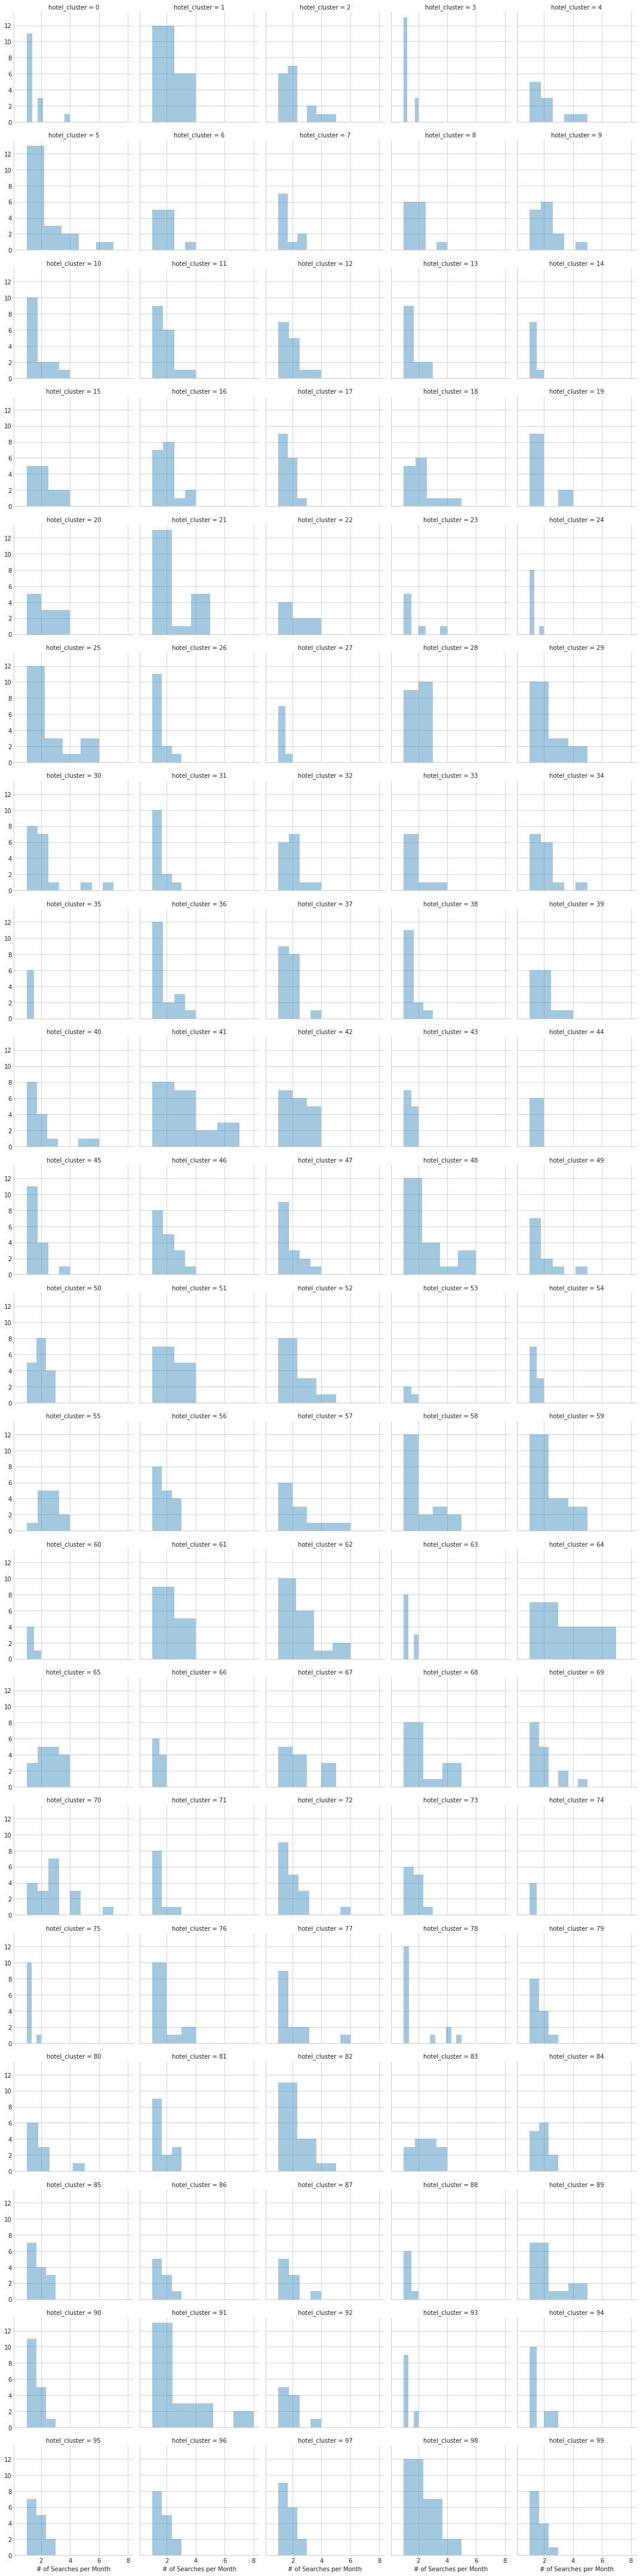

In [8]:
# fig, ax = plt.subplots()
# fig.set_size_inches(20, 10)

train_df = datasets[0]

temp = train_df[['hotel_cluster', 'date']].sample(N_SAMPLES)
temp = temp.groupby(['hotel_cluster', 'date']).size().reset_index(name='# of Searches per Month')
# temp['date'].apply(re.sub('-', '', temp['date']))

eda_plt = sb.FacetGrid(col='hotel_cluster', data=temp, col_wrap=5)
eda_plt = eda_plt.map(sb.distplot, '# of Searches per Month', hist=True, kde=False)

plt.show()

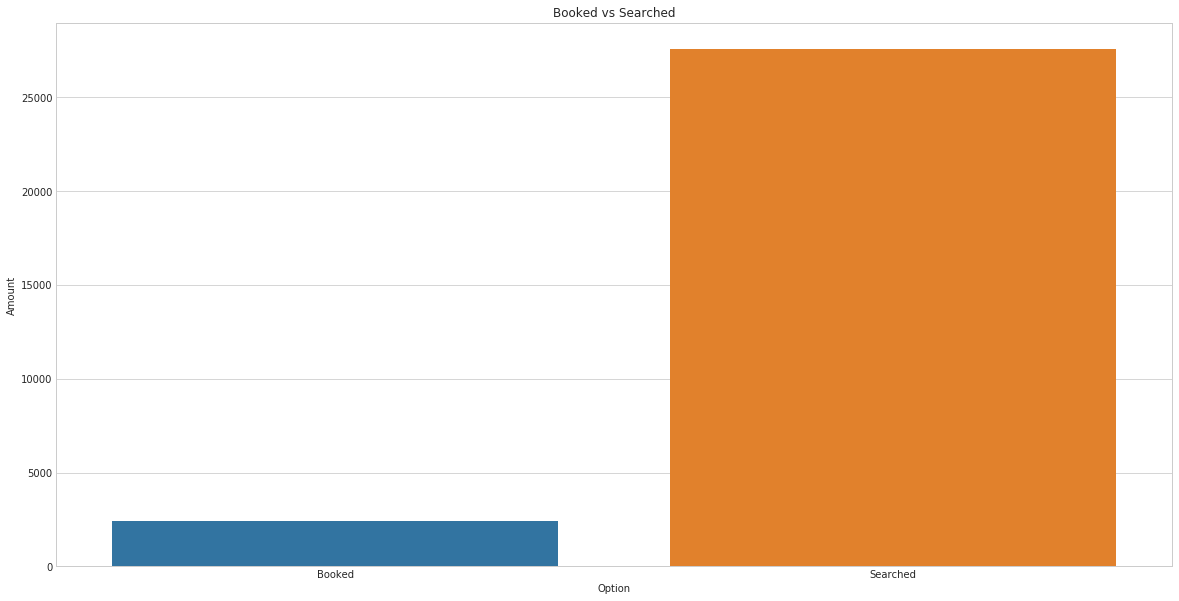

In [9]:
#Exploit the option to see whether user search or booked

#Put the data for people who booked in one dataframe
#The people who searched in another
book = train_df[train_df.is_booking == 1]
search = train_df[train_df.is_booking == 0]

#First see what the comparison is between amount searched and booked
d = {'Option' : pd.Series(['Booked', 'Searched']),'Amount' : pd.Series([len(book), len(search)])}
df = pd.DataFrame(d)

# print(df.head())

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

ax.set_title('Booked vs Searched')

options_plt = sb.barplot(x='Option', y = 'Amount', data = df)

plt.show()

##### Booked vs. Searched Frequencies
--------------------------------------------------------------------------------

These results are as to be expected. People will tend to browse hotel options before booking. Next we will find the frequency of specific users who searched.

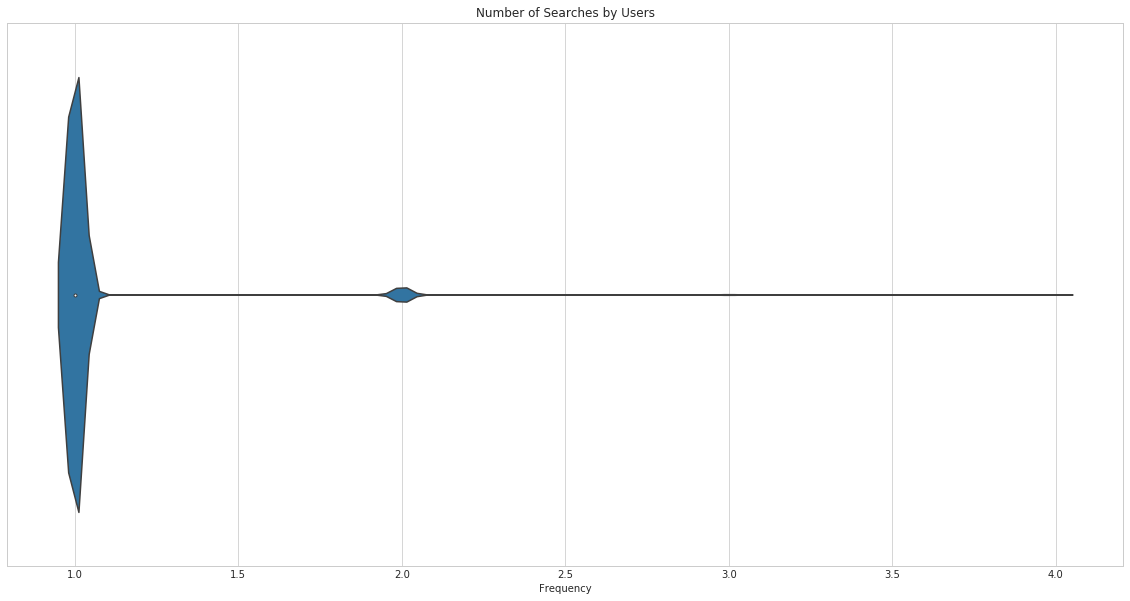

In [10]:
#To find the breakdown we will use dataframes built in value_counts function to find frequencies of users
user_frequency = search['user_id'].value_counts()
user_df = pd.DataFrame(user_frequency)

#Change column name to frequency so it makes more sense
user_df = user_df.rename(index=str, columns={"user_id": "Frequency"})
user_df['User'] = user_frequency.index

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

ax.set_title('Number of Searches by Users')

ax = sb.violinplot(x=user_df['Frequency'])

plt.show()

##### Distribution of Number of Searches per User
--------------------------------------------------------------------------------
Most people only searched for 1 thing, per user session. Purely speculating, but it seems as if people use Expedia to quickly compare hotel prices against other websites perhaps, rather than scrolling through deeper through Expedia to find these hotels.

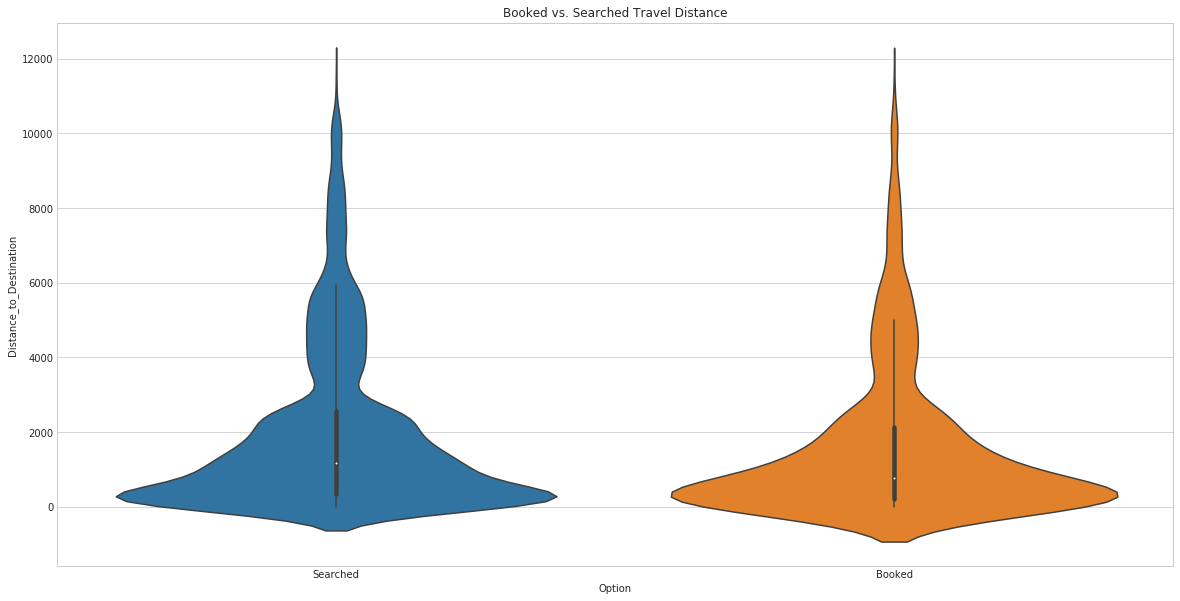

In [11]:
#Replace numbers with names
name_df = train_df.copy()
name_df['is_booking'] = name_df['is_booking'].map({1: 'Booked', 0: 'Searched'})

#Make names nicer
name_df = name_df.rename(index=str, columns={"is_booking": "Option", "orig_destination_distance": "Distance_to_Destination"})

#As would be expected be search way more than they book. 
#We are going to examine all available aspects of the data to see if there is any coorlations

#We want to first see if distance affected things. We will use a violen plot to see the comparison
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

ax.set_title('Booked vs. Searched Travel Distance')

ax = sb.violinplot(x='Option', y='Distance_to_Destination', data = name_df)

plt.show()

##### Booked vs. Searched Travel Distance
--------------------------------------------------------------------------------
These graphs look pretty similar. But it is hard to really understand with such a huge range of distances. While the bulk may look in the low range, it is important to note that the top of the lower half here is around 4000 miles. So we will truncate the data to see the breakdown of the bulk of the data. It is also interesting to note that up until a little under 4000 miles the amount of searches decreases. But people do not seem to mind the extra 2000 miles from 4000 to 6000. We also see a larger trend of booked hotels of shorter distances. For further analysis we are going to examine the bulk. We will determine the subgroup based on the data statistics

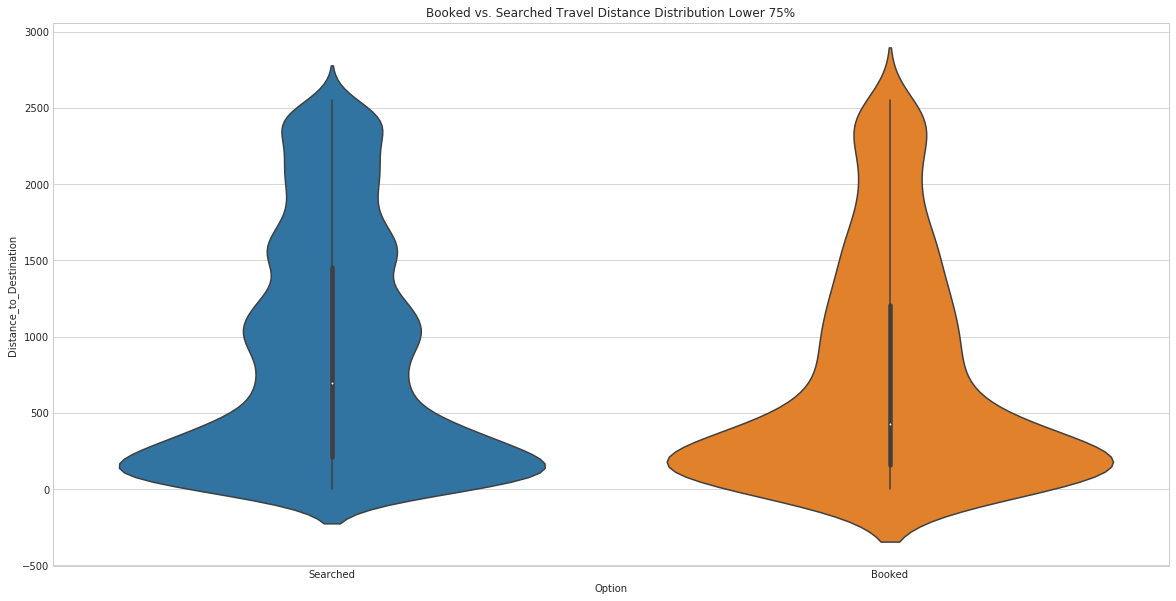

In [12]:
#Use describe to define statistics about dataframe
# print(name_df.describe())
upper_bound = name_df['Distance_to_Destination'].quantile(q=0.75)

#Upon analyzing the data we see that 75% of the data falls below 2554 miles. 
#We will make that our cutoff for the closer examination
majority_sample = name_df[name_df.Distance_to_Destination < upper_bound]

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

ax.set_title('Booked vs. Searched Travel Distance Distribution Lower 75%')

ax = sb.violinplot(x='Option', y='Distance_to_Destination', data = majority_sample)

plt.show()

##### Booked vs. Searched Travel Distance Distribution Lower 75%
--------------------------------------------------------------------------------
These plots look relatively similar to the larger version with a little more distribution. There is still a larger tendancy to stay close to home. The booked graph shows a more gradual decline as people get further from home. Generally both the searched and booked follow the same trend.

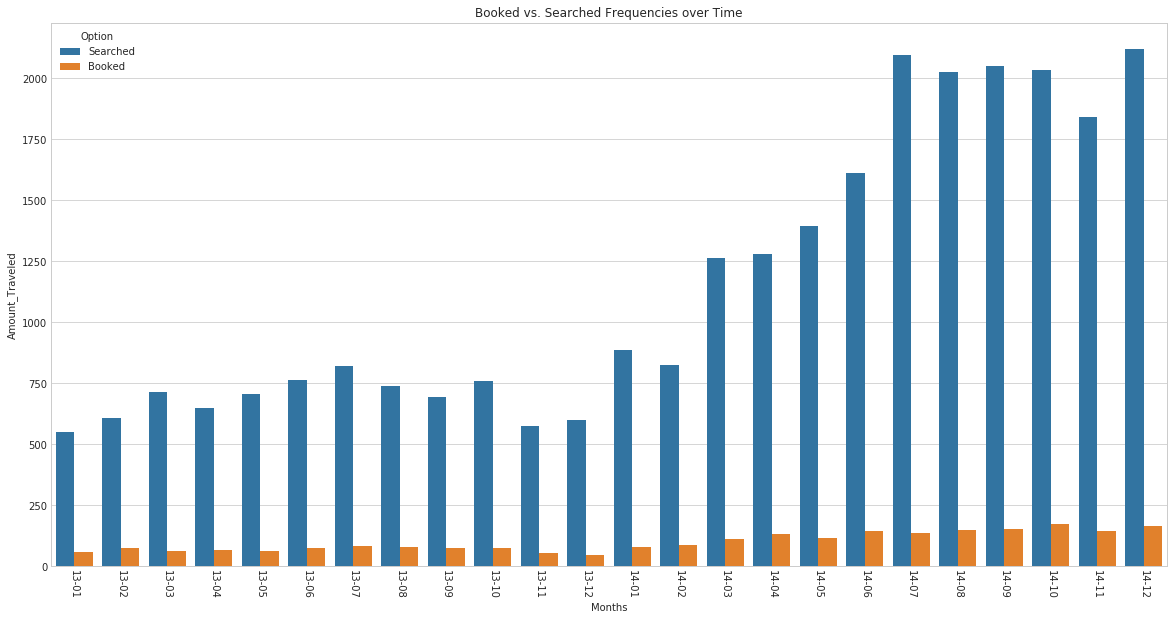

In [13]:
#Now that we've seen how distance effects hotel searching and booking lets look for popular months
#To do this we need to get the frequency months in both the book and search dataframe

#Get the frequency count of booked months using value_counts
book_months = book['date'].value_counts()

#Get the frequency count of searched months using the same method
search_months = search['date'].value_counts()

#Create searched data frame
d = {'Months' : search_months.index, 'Amount_Traveled' : search_months}     
search_df = pd.DataFrame(d)
search_df['Option'] = 'Searched'
search_df = search_df.sort_values(by=['Months'])

#create booked dataframe
d = {'Months' : book_months.index , 'Amount_Traveled' : book_months}
book_df = pd.DataFrame(d)
book_df['Option'] = 'Booked'
book_df = book_df.sort_values(by=['Months'])

#append the two to check
all_time = search_df.append(book_df)
all_time = all_time.sort_values(by=['Months'])


#The data distribution is severe enough between searched an booked that it would be 
#benificial to break them up rather than compare them side by side.
#To show what we mean we have created a graph comparing them side by side
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

ax.set_title('Booked vs. Searched Frequencies over Time')

ax = sb.barplot(x="Months", y="Amount_Traveled", hue="Option", data=all_time)

plt.xticks(rotation=270)
plt.show()

##### Booked vs. Searched Frequencies over Time
--------------------------------------------------------------------------------
The search data overhwelms the booked data. We can see patterns in search data but the only thing this graph shows us is there are much more searches than booked, which we already knew. So we create a split graph and observe each one individually

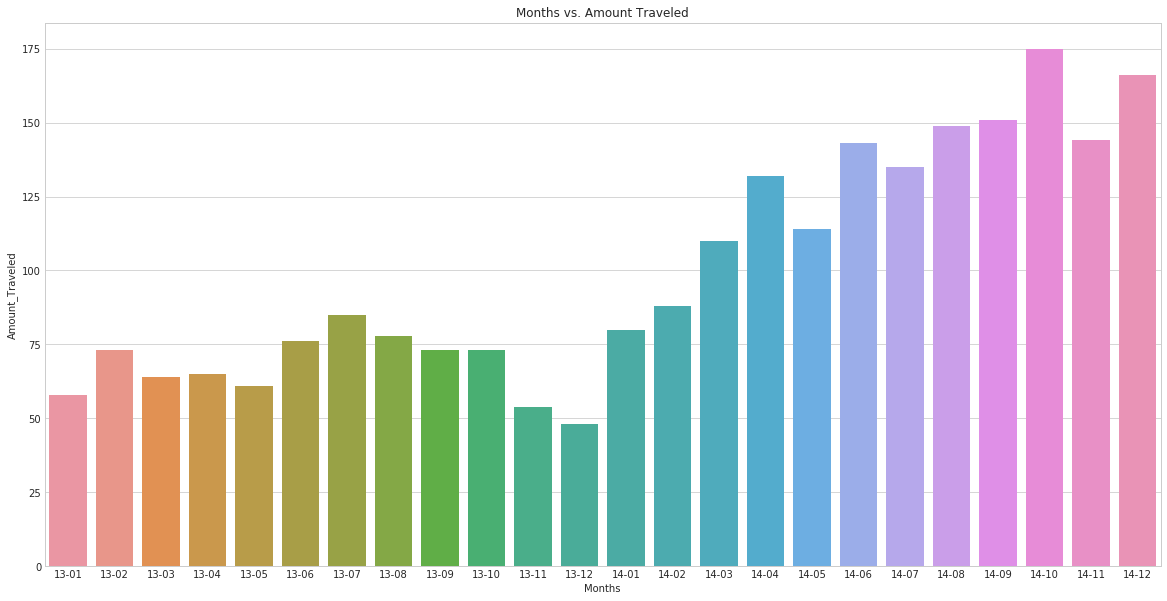

In [14]:
#Graph for Months vs Amount traveled when booked
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

ax.set_title('Months vs. Amount Traveled')

ax = sb.barplot(x="Months", y="Amount_Traveled", data=book_df)

# plt.xticks(rotation=270)
plt.show()

##### Months vs. Amount Traveled
--------------------------------------------------------------------------------
We only plotted the book data because the search data is evident in the previous graph. There are no overhwelming differences in the graphs. One noticable attribute of the graph is  a sharp increase in hotel searches and bookings. there is also no real focus on a season. Assuming this is due to a global data sampling peak travel happens at different times.

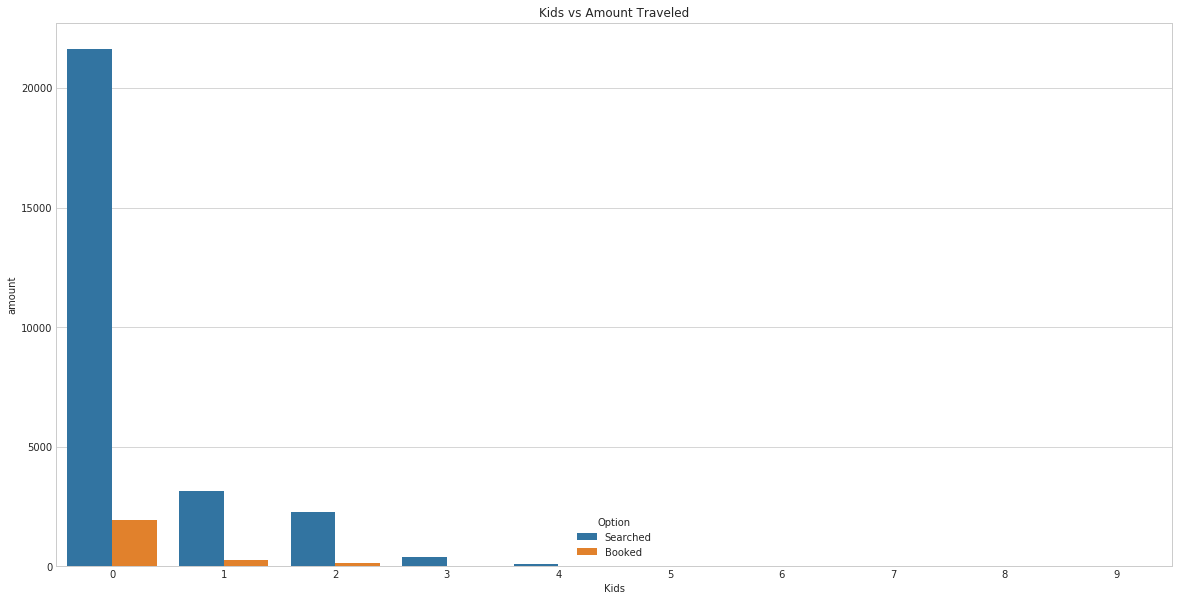

In [15]:
dist_df = name_df.copy()

#frequency of kids for people who booked
book_kids_amount = book['srch_children_cnt'].value_counts()

#frequency of kids for people who searched
search_kids_amount = search['srch_children_cnt'].value_counts()

#Create searched data frame
d = {'Kids' : pd.Series(range(0,10)), 'amount' : search_kids_amount}     
search_df = pd.DataFrame(d)
search_df['Option'] = 'Searched'

#create booked dataframe
d = {'Kids' : pd.Series(range(0,10)) , 'amount' : book_kids_amount}
book_df = pd.DataFrame(d)
book_df['Option'] = 'Booked'

#append the two to check
all_kids = search_df.append(book_df)

#Next we will see a comparison of how kids play in
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

ax.set_title('Kids vs Amount Traveled')

ax = sb.barplot(x="Kids", y="amount", hue="Option", data=all_kids)

plt.show()

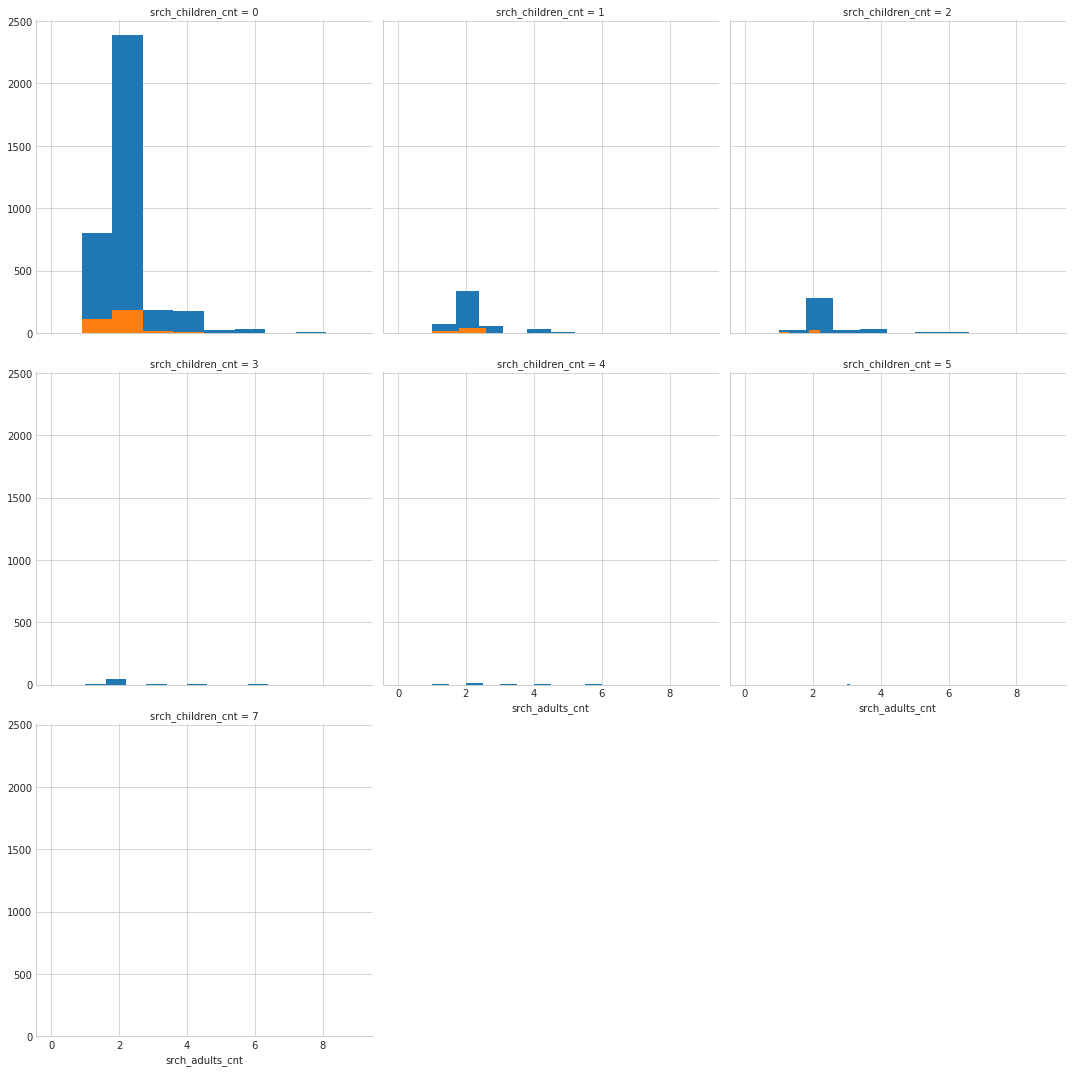

In [16]:
temp = train_df[['srch_children_cnt', 'srch_adults_cnt', 'is_booking']].sample(5000)

# value_counts = [temp['srch_children_cnt'].value_counts(), temp['srch_adults_cnt'].value_counts(), temp['is_booking'].value_counts()]
# print(value_counts)

childxadult_plt = sb.FacetGrid(col='srch_children_cnt', hue='is_booking', data=temp, col_wrap=3, size=5)
childxadult_plt = childxadult_plt.map(plt.hist, 'srch_adults_cnt')

plt.show()

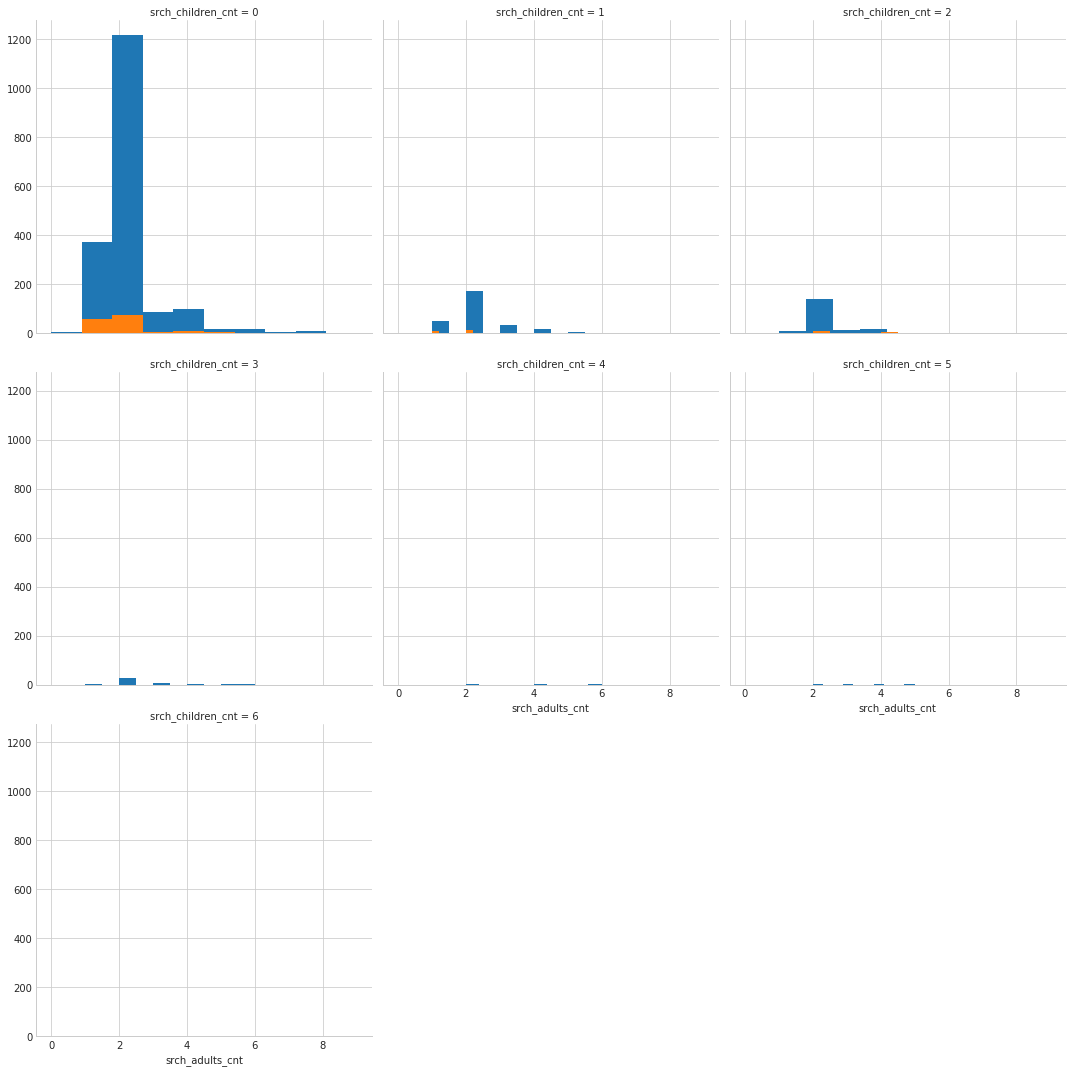

In [17]:
temp = train_df[['srch_children_cnt', 'srch_adults_cnt', 'is_booking']].sample(N_SAMPLES)

# value_counts = [temp['srch_children_cnt'].value_counts(), temp['srch_adults_cnt'].value_counts(), temp['is_booking'].value_counts()]
# print(value_counts)

childxadult_plt = sb.FacetGrid(col='srch_children_cnt', hue='is_booking', data=temp, col_wrap=3, size=5)
childxadult_plt = childxadult_plt.map(plt.hist, 'srch_adults_cnt')

plt.show()

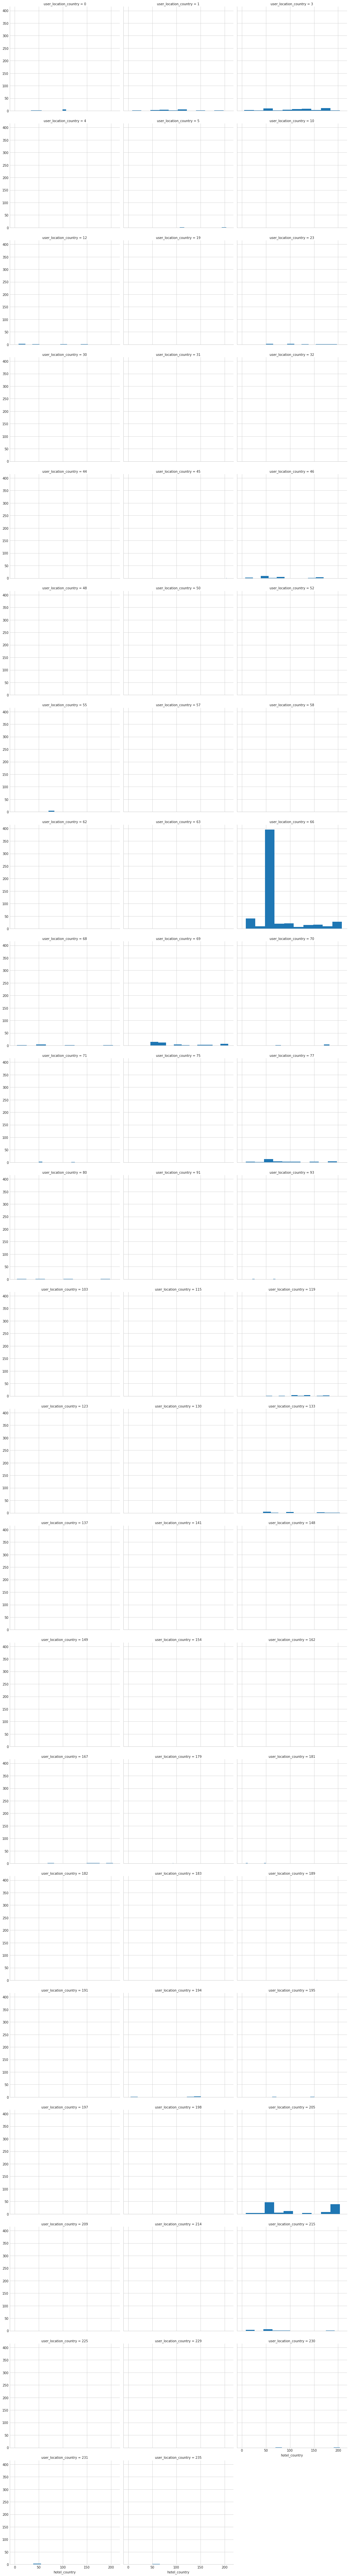

In [18]:
temp = train_df[['user_location_country', 'hotel_country']].sample(1000)

#Plot the user location vs hotel location for both searches and bookings
country_plt = sb.FacetGrid(col='user_location_country', data=temp, col_wrap=3, size=5)
country_plt = country_plt.map(plt.hist, 'hotel_country')

plt.show()

##### Number of Adults vs. Children 
##### Hotel Countries vs. User Countries
--------------------------------------------------------------------------------
We see here that there are too many plots, hotels, and countries to allow any close observations. A noticable trend is almost all of the countries have empty graphs, while one dominates. Next take the top ten recurrences of user location and hotel location and use those as the new datapoints for the graphs

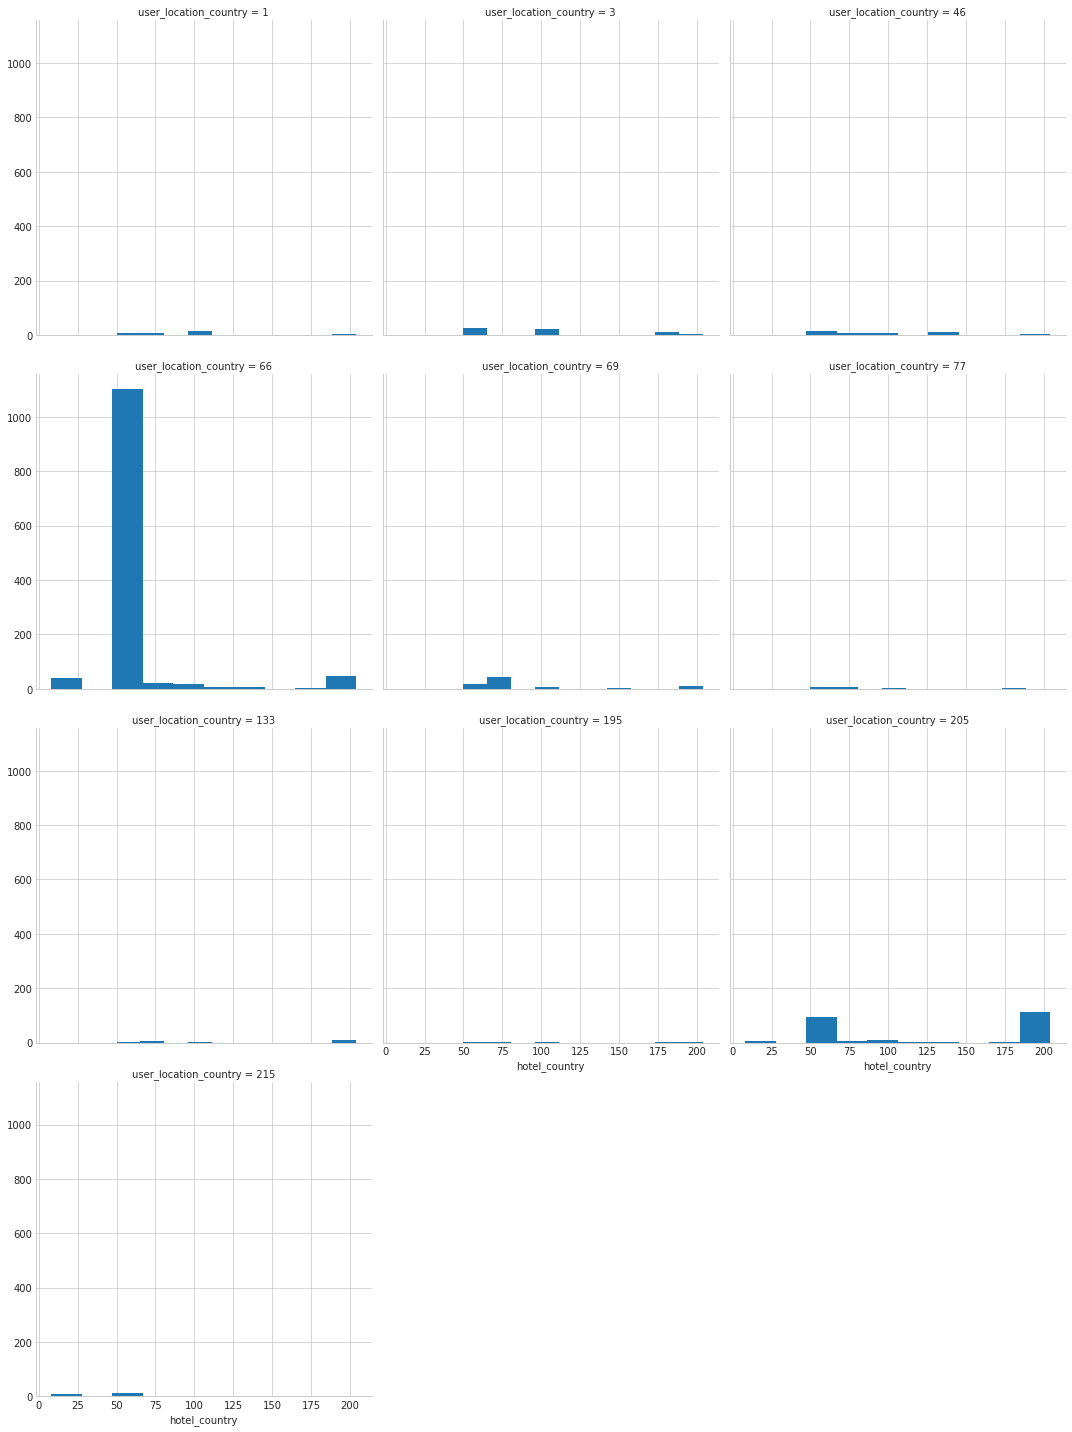

In [19]:
#take the location of user and hotel from the book since we are calculating off of that
temp = book[['user_location_country', 'hotel_country']]

#Get the user country and hotel country frequencies
user_location = temp['user_location_country'].value_counts()
hotel_location = temp['hotel_country'].value_counts()

#only take sample of the first 10 and fee it into d as the data for our dataframe
d = {'user_location': user_location.index[:10], 'hotel_location': hotel_location.index[:10]}
cntry_df = pd.DataFrame(d)

#Want to filter out anyone but the top 10 from our DataFrame
#initialize temp storage array
tmp_arr = []
#Iterate through rows of cntry dataframe
for index, row in cntry_df.iterrows():
    #append to temp arr a series of all the rows of the column user country from temp.
    tmp_arr += [temp[temp.user_location_country == row['user_location']]]

#Concat the temp_arr and set as temp1
temp1 = pd.concat(tmp_arr)

#Initialize temp array again and repeat process with hotel location
tmp_arr = []
for index, row in cntry_df.iterrows():
    tmp_arr += [temp1[temp1.hotel_country == row['hotel_location']]]

#concat to temp1 for the graphable dataframe
temp1 = pd.concat(tmp_arr)

#This code block removes the top one. It dominates the graph, I'll display with it remove
#to see better visual
# temp1 = temp1[temp1.user_location_country != 66]
# temp1 = temp1[temp1.hotel_country != 66]

#Plot the user location vs hotel location for both searches and bookings
book_country_plt = sb.FacetGrid(col='user_location_country', data=temp1, col_wrap=3, size=5)
book_country_plt = book_country_plt.map(plt.hist, 'hotel_country')

plt.show()

--------------------------------------------------------------------------------
Whatever country 66 is uses a lot of hotels. We need to drop it to see normal trends

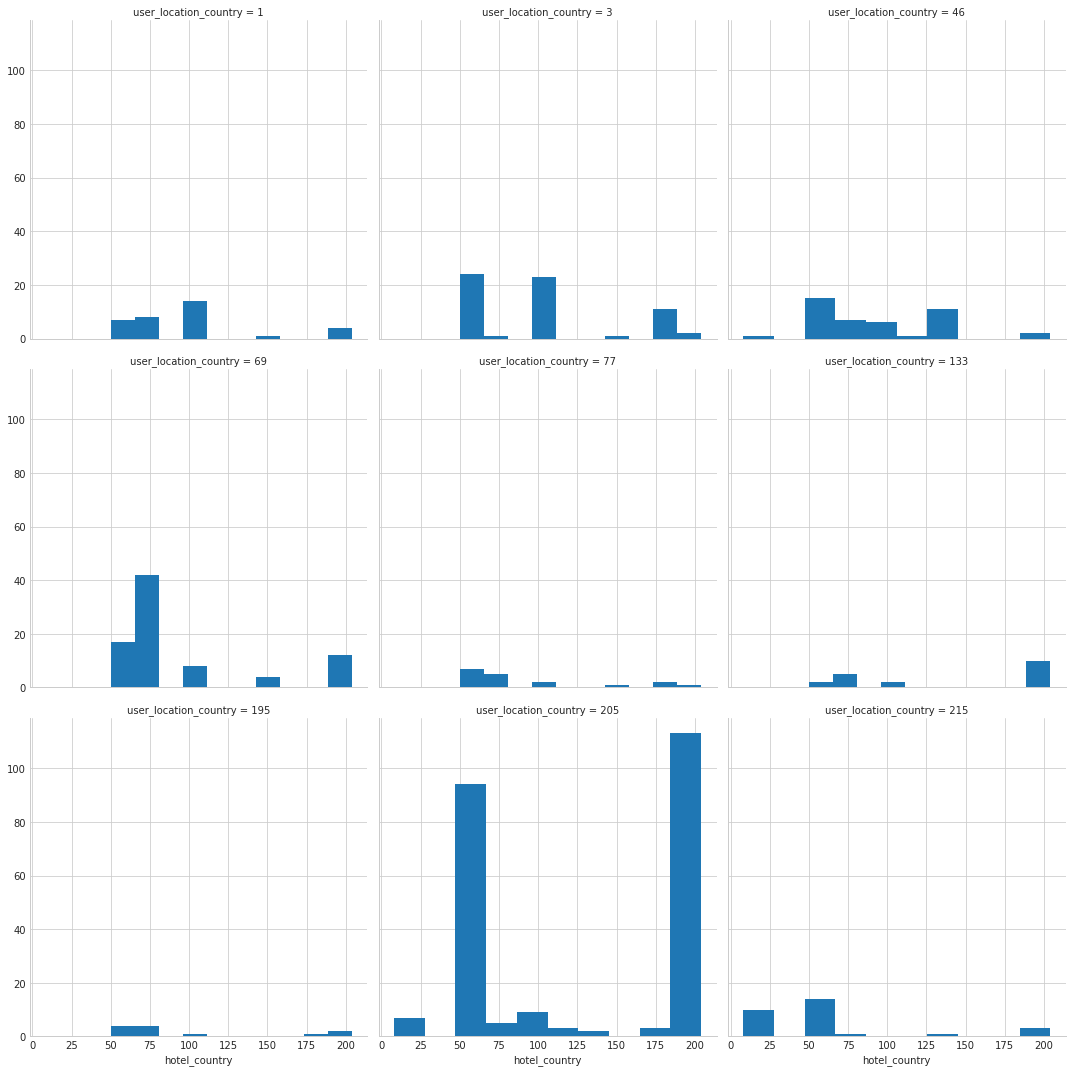

In [20]:
#take the location of user and hotel from the book since we are calculating off of that
temp = book[['user_location_country', 'hotel_country']]

#Get the user country and hotel country frequencies
user_location = temp['user_location_country'].value_counts()
hotel_location = temp['hotel_country'].value_counts()

#only take sample of the first 10 and fee it into d as the data for our dataframe
d = {'user_location': user_location.index[:10], 'hotel_location': hotel_location.index[:10]}
cntry_df = pd.DataFrame(d)

#Want to filter out anyone but the top 10 from our DataFrame
#initialize temp storage array
tmp_arr = []
#Iterate through rows of cntry dataframe
for index, row in cntry_df.iterrows():
    #append to temp arr a series of all the rows of the column user country from temp.
    tmp_arr += [temp[temp.user_location_country == row['user_location']]]

#Concat the temp_arr and set as temp1
temp1 = pd.concat(tmp_arr)

#Initialize temp array again and repeat process with hotel location
tmp_arr = []
for index, row in cntry_df.iterrows():
    tmp_arr += [temp1[temp1.hotel_country == row['hotel_location']]]
    
#concat to temp1 for the graphable dataframe
temp1 = pd.concat(tmp_arr)

#Better to see display of all others with this gone
temp1 = temp1[temp1.user_location_country != 66]
temp1 = temp1[temp1.hotel_country != 66]

#Plot the user location vs hotel location for both searches and bookings
book_country_plt = sb.FacetGrid(col='user_location_country', data=temp1, col_wrap=3, size=5)
book_country_plt = book_country_plt.map(plt.hist, 'hotel_country')

plt.show()

--------------------------------------------------------------------------------
Data looks skewed still with 66 removed. This graph shows that the data describes the locations of interest apparently at 66 and 205.

### [4] Hypothesis & Statistical Testing, Machine Learning
--------------------------------------------------------------------------------
[4.1] Since the competition rules list that the Mean Average Precision @ 5 will be used to as the evaluating score function, we will be using `sklearn.cross_validation.average_precision_score()` to evaluate our predictions. This also means that our predictions should be in the form of sets of the 5 most likely classifications for each input feature vector.  <br /><br />
[4.2] We separated our variables by type (categorical vs. quantitative), and retrieved the Coefficient Correlation Matrix for both the categorical variables and the numerical ones, requesting Spearman's and Pearson's `r` Coefficient respectively. Looking over the matrices, we can see that there's almost no correlation to any of these values ([-1:1]). There does seem so be at least some instances of mediocre correlation (&lt;0.3-4), but it seems as if only for location based attributes, which is is uninformative. Thus since our variables have such a tenuous correlation coefficient, we should steer away from Linear Classification. (But perhaps visit it in the future).   <br /><br />
[4.3] Our baseline algorithm to compare against was simply predicting, for every observation in the training set, the 5 most frequently searched hotel clusters as the 5 most likely classes. Here we're providing the lower bound benchmark - what happens due to random chance?  <br /><br />
[4.4] We first instantiated a KNearestNeighborClassifier using a subset of chosen features, and evaluated its performance using [4.1]. <br /><br />
[4.5] Next was the RandomForestClassifier. These classifiers work well for highly categorical data, from which pure mathematical functions rarely work well a.k.a. non-parametric distributions. We could have done many things with the Random Forest, including increasing the size of the forest, competing forest decisions against each other, etc.<br /><br />

--------------------------------------------------------------------------------
========================================

In [21]:
# frequency count of 5 most popular hotel clusters from training sample

freq_df = pd.DataFrame(train_df['hotel_cluster'].copy())
freq_df.columns = ['actual']

freq_predictions = train_df['hotel_cluster'].value_counts().head().index.tolist()
freq_df['freq_predict'] = [freq_predictions for i in range(freq_df.shape[0])]

print(np.matrix(freq_df))

freq_df.head()

[[33 list([91, 41, 48, 64, 65])]
 [46 list([91, 41, 48, 64, 65])]
 [32 list([91, 41, 48, 64, 65])]
 ..., 
 [99 list([91, 41, 48, 64, 65])]
 [12 list([91, 41, 48, 64, 65])]
 [98 list([91, 41, 48, 64, 65])]]


,actual,freq_predict
25258247,33,"[91, 41, 48, 64, 65]"
26946834,46,"[91, 41, 48, 64, 65]"
31976059,32,"[91, 41, 48, 64, 65]"
22771109,91,"[91, 41, 48, 64, 65]"
19546379,63,"[91, 41, 48, 64, 65]"


In [22]:
y = freq_df['actual'].values
y = label_binarize(y, classes=list(range(0,100)))

temp = [freq_predictions[0] for i in range(freq_df.shape[0])]
x = label_binarize(temp, classes=list(range(0,100)))

sklearn.metrics.average_precision_score(y, x)

0.0099999999999999985

In [23]:
cat_vars = ['site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_destination_id', 'srch_destination_type_id', 'hotel_continent', 'hotel_country', 'hotel_market', 'is_booking', 'cnt', 'hotel_cluster']

cats = train_df[cat_vars]
cats.corr(method='spearman')

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market,is_booking,cnt,hotel_cluster
site_name,1.000000,-0.629383,0.222211,-0.021779,-0.019617,0.039975,-0.019258,0.055042,-0.063862,-0.003457,-0.012068,0.219341,0.301607,-0.125929,-0.023450,0.019738,-0.035724
posa_continent,-0.629383,1.000000,0.228342,0.177685,0.071525,-0.018884,0.019638,-0.086544,0.111142,0.034070,0.044539,-0.323427,-0.210148,0.134645,0.022383,-0.020942,0.022794
user_location_country,0.222211,0.228342,1.000000,0.198518,0.114991,-0.018546,0.021725,-0.004552,0.087425,0.007737,0.019767,-0.060695,0.043997,0.037657,0.001005,-0.009483,-0.015554
user_location_region,-0.021779,0.177685,0.198518,1.000000,0.137552,-0.001306,0.023144,0.033370,0.022761,0.030970,0.008739,-0.044730,-0.088946,0.071573,0.016260,-0.005260,0.004269
user_location_city,-0.019617,0.071525,0.114991,0.137552,1.000000,-0.006958,0.000054,0.013538,0.029445,0.005065,-0.000527,-0.014485,-0.017507,0.019870,0.001749,-0.008840,0.006197
user_id,0.039975,-0.018884,-0.018546,-0.001306,-0.006958,1.000000,-0.011579,-0.009047,0.005332,0.013103,0.008054,0.018736,0.009636,-0.011302,-0.011781,0.001705,0.008508
is_mobile,-0.019258,0.019638,0.021725,0.023144,0.000054,-0.011579,1.000000,0.063092,-0.027218,-0.009278,-0.020668,-0.022197,-0.028887,0.024799,-0.033886,0.006987,0.006491
is_package,0.055042,-0.086544,-0.004552,0.033370,0.013538,-0.009047,0.063092,1.000000,-0.014772,-0.144717,-0.231294,0.155147,-0.054069,-0.056006,-0.075040,0.110405,0.042945
channel,-0.063862,0.111142,0.087425,0.022761,0.029445,0.005332,-0.027218,-0.014772,1.000000,0.002084,0.026977,-0.035718,-0.011761,0.019222,0.018875,-0.017178,-0.000507
srch_destination_id,-0.003457,0.034070,0.007737,0.030970,0.005065,0.013103,-0.009278,-0.144717,0.002084,1.000000,0.518236,0.022703,0.074218,0.102928,0.024089,-0.013234,-0.013534


In [24]:
# check Pearson's Correlation Coefficient (r) values for every search feature against each other

rcorrs = train_df.corr()    
rcorrs

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,y_train
site_name,1.000000,-0.632416,0.157040,0.116247,-0.019191,0.024316,0.031827,-0.008361,0.061145,-0.032824,...,0.009119,0.031076,-0.011963,-0.019110,0.022003,0.194298,0.262284,-0.071576,-0.036458,-0.036458
posa_continent,-0.632416,1.000000,0.175737,-0.012001,0.042742,0.042740,-0.014907,0.014651,-0.098281,0.095033,...,-0.020483,-0.004712,0.039816,0.018845,-0.018639,-0.324803,-0.151649,0.057524,0.022761,0.022761
user_location_country,0.157040,0.175737,1.000000,0.055213,0.121890,0.037265,-0.022082,0.006568,-0.028669,0.109110,...,0.007919,0.008144,0.024566,0.003017,-0.009356,-0.067050,0.096312,0.022123,-0.017252,-0.017252
user_location_region,0.116247,-0.012001,0.055213,1.000000,0.131016,0.147284,0.001361,0.023004,0.038859,0.005584,...,-0.001833,0.030161,0.007816,0.012222,-0.008907,0.030103,-0.065713,0.043962,0.001801,0.001801
user_location_city,-0.019191,0.042742,0.121890,0.131016,1.000000,0.000970,-0.007084,0.000348,0.013897,0.029475,...,-0.001300,0.007570,-0.000211,0.001782,-0.011944,-0.005715,-0.013717,0.020079,0.005750,0.005750
orig_destination_distance,0.024316,0.042740,0.037265,0.147284,0.000970,1.000000,0.012265,-0.058633,0.038989,-0.006450,...,-0.010956,-0.024289,-0.039658,-0.051002,0.007675,0.411058,0.248848,-0.072236,0.013017,0.013017
user_id,0.031827,-0.014907,-0.022082,0.001361,-0.007084,0.012265,1.000000,-0.011533,-0.009068,0.006252,...,-0.003130,0.008274,0.009892,-0.011799,-0.006690,0.015287,0.007485,-0.005974,0.008523,0.008523
is_mobile,-0.008361,0.014651,0.006568,0.023004,0.000348,-0.058633,-0.011533,1.000000,0.063092,-0.032236,...,-0.026326,-0.013195,-0.021771,-0.033886,-0.003677,-0.021700,-0.022230,0.016302,0.005952,0.005952
is_package,0.061145,-0.098281,-0.028669,0.038859,0.013897,0.038989,-0.009068,0.063092,1.000000,-0.015089,...,-0.041313,-0.143446,-0.227688,-0.075040,0.122794,0.111998,-0.037931,-0.023004,0.040336,0.040336
channel,-0.032824,0.095033,0.109110,0.005584,0.029475,-0.006450,0.006252,-0.032236,-0.015089,1.000000,...,0.011475,-0.005318,0.031152,0.020079,-0.012049,-0.027640,-0.000081,0.010037,-0.000347,-0.000347



##### Principal Component Analysis
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
========================================

In [25]:
pca = PCA(n_components=5)
# dest_pca = dest_pca.fit_transform(dest_df.iloc[:,1:])
dest_pca = pca.fit_transform(dest_df.iloc[:,1:])
dest_pca = pd.DataFrame(dest_pca)
dest_pca.head()

,0,1,2,3,4
0,-0.044268,0.169419,0.032523,-0.014275,-0.069685
1,-0.440761,0.077405,-0.091572,-0.020238,0.013212
2,0.001033,0.020677,0.012109,0.134158,0.142024
3,-0.480467,-0.040345,-0.019320,-0.040103,-0.027388
4,-0.207253,-0.042694,-0.011744,-0.017520,-0.019880


In [26]:
temp = train_df[['hotel_continent', 'site_name', 'srch_rm_cnt', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_id', 'cnt', 'hotel_cluster']].copy().dropna()
onehot = pd.get_dummies(temp[['hotel_continent', 'site_name', 'srch_rm_cnt', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_id', 'cnt']])
temp = temp.drop(['hotel_continent', 'site_name', 'srch_rm_cnt', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_id', 'cnt'], axis=1)
temp = temp.join(onehot)

In [27]:
temp

,hotel_cluster,hotel_continent,site_name,srch_rm_cnt,srch_adults_cnt,srch_children_cnt,srch_destination_id,cnt
25258247,33,2,34,1,1,0,12615,1
26946834,46,6,2,1,1,0,8407,1
31976059,32,2,2,1,2,0,8232,1
22771109,91,2,2,2,6,1,328,4
19546379,63,3,2,1,2,0,18569,2
2714392,64,6,2,1,2,1,8255,1
35987219,64,6,2,1,1,0,8213,1
16567782,5,2,2,1,1,0,8277,2
27165880,20,6,2,2,4,1,8788,1
24390176,57,6,8,1,2,1,8740,1


In [28]:
# print(dist)
# print(temp['hotel_cluster'].shape)
# print(temp.head())
# print(onehot.head())
# print(temp.columns)
# print(temp.shape)
print(train_df[cat_vars].head())


          site_name  posa_continent  user_location_country  \
25258247         34               3                    205   
26946834          2               3                     66   
31976059          2               3                     66   
22771109          2               3                     66   
19546379          2               3                     23   

          user_location_region  user_location_city  user_id  is_mobile  \
25258247                   354               25315   550266          0   
26946834                   196                2428   899461          0   
31976059                   435               40631   973944          0   
22771109                   442               35390   982612          0   
19546379                    48                4924   113361          0   

          is_package  channel  srch_destination_id  srch_destination_type_id  \
25258247           0        9                12615                         5   
26946834           0  

In [29]:
neighbors = KNN()
# neighbors.fit(temp[cat_vars], train_df['hotel_cluster'])
neighbors.fit(temp[['hotel_continent', 'site_name', 'srch_rm_cnt', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_id', 'cnt']], train_df['hotel_cluster'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [30]:
# neighbors.fit([[i] for i in train_df[['srch_adults_cnt', 'srch_children_cnt', ]]], train_df['hotel_cluster'])
#     # ['site_name', 'user_location_country', 'orig_destination_distance', 'srch_adults_cnt', 'srch_rm_cnt', 'srch_destination_id', 'hotel_continent', 'hotel_country']
    

print(X_train.columns)
print(X_train.shape)

predicted = neighbors.predict(X_train[['hotel_continent', 'site_name', 'srch_rm_cnt', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_id', 'cnt']])
print(predicted)

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster', 'y_train', 'date'],
      dtype='object')
(30000, 26)
[ 2 46 16 ..., 11 12 95]


In [31]:
# predictors = [c for c in train_df.columns if c not in train_df['hotel_cluster']]


# clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
# scores = cross_validation.cross_val_score(neighbors, temp[predictors], train_df['hotel_cluster'], cv=3)
# scores

In [32]:
# X_train, X_test, y_train, y_test = train_test_split(train_df[['site_name', 'user_location_country', 'user_location_region', 'user_location_city', 'srch_rm_cnt', 'srch_children_cnt', 'srch_adults_cnt', 'srch_destination_type_id', 'srch_destination_id', 'hotel_continent', 'hotel_country', 'hotel_market']], train_df['hotel_cluster'], test_size=0.7, stratify=train_df['hotel_cluster'], random_state=314159)
# print(X_train.head())
# print(y_train.head())

In [37]:
print(X_train.columns)

X_train, X_test, y_train, y_test = train_test_split(train_df[['site_name', 'user_location_country', 'user_location_region', 'user_location_city', 'srch_rm_cnt', 'srch_children_cnt', 'srch_adults_cnt', 'srch_destination_type_id', 'srch_destination_id', 'hotel_continent', 'hotel_country', 'hotel_market']], train_df['hotel_cluster'], test_size=0.7, stratify=train_df['hotel_cluster'], random_state=314159)

rForests = RandomForestClassifier(n_estimators=100, min_weight_fraction_leaf=0.1)
# predictors = [c for c in train_df.columns if c not in train_df['hotel_cluster']]


# rForests.fit([[i] for i in train_df['srch_adults_cnt']], train_df['hotel_cluster'])
# rForests.fit(X_train.values.reshape(-1, 1), y_train)
rForests.fit(X_train.values, y_train)

# scores = cross_validation.cross_val_score(rForests, temp[predictors], train_df['hotel_cluster'], cv=3)
# predictors

Index(['site_name', 'user_location_country', 'user_location_region',
       'user_location_city', 'srch_rm_cnt', 'srch_children_cnt',
       'srch_adults_cnt', 'srch_destination_type_id', 'srch_destination_id',
       'hotel_continent', 'hotel_country', 'hotel_market'],
      dtype='object')


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.1, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
# predicted = rForests.predict(X_test.values.reshape(-1, 1))
predicted = rForests.predict(X_train.values)
predicted

array([64, 64, 91, ..., 91, 64, 91])

In [39]:
pred = pd.DataFrame([predicted.tolist(), y_train.tolist()]).T
pred.columns = ['pred', 'actual']
print(pred.head())
pred = pd.get_dummies(columns=['pred', 'actual'], data=pred)
# print(pred)
# predicted.head()

pred = pd.get_dummies(predicted.tolist())
actual = pd.get_dummies(y_train.tolist())

pred.head()

X_train, X_test, y_train, y_test =  train_test_split(train_df, train_df['hotel_cluster'], test_size=0.7, stratify=train_df['hotel_cluster'], random_state=314159)

   pred  actual
0    64       2
1    64      67
2    91      80
3    65      57
4    91      68


In [40]:
average_precision_score(actual, pred)

0.010775764893839176

In [41]:
# # randforest_predictions = rForests.predict([[i] for i in train_df['srch_adults_cnt']])
# # print(np.unique(predicted))
# # print(y_train.unique)

# predictions = pd.DataFrame(columns=['actual', 'p1', 'p2', 'p3', 'p4', 'p5'])

# rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=314159)
# temp = []
# predictions['actual'] = y_train

# for trindx, teindx in rkf.split(train_df):
#     print(trindx[:10])
#     rForests.fit(trindx, trindx['hotel_cluster'])
# #     rForests = 
#     temp += [rForests.predict(teindx)]
    
# print(temp[:10])

# # cross_validation.cross_val_score(X_test, y=y_train)

In [42]:
# neighbors.predict([[0, 0, 0, 0, 0, 1]])
# 
# temp_test = train_df[['hotel_continent', 'site_name', 'srch_rm_cnt', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_id', 'cnt']].sample(temp.shape[0])
# temp_test = train_df[['srch_adults_cnt', 'srch_children_cnt']].sample(temp.shape[0])
# print(temp_test.shape)
# print(temp.shape)

# knn_preds = neighbors.predict(temp_test)

In [43]:
# predictions = pd.DataFrame(train_df['hotel_cluster'])


# predictions['knn_preds'] = knn_preds




# predictions.head()

In [44]:


# predictions['actual'] = train_df['hotel_cluster']

# y = freq_df['actual'].values
# y = label_binarize(y, classes=list(range(0,100)))

# temp = [freq_predictions[0] for i in range(freq_df.shape[0])]
# x = label_binarize(temp, classes=list(range(0,100)))

# sklearn.metrics.average_precision_score(y, x)

### [5] Insight & Conclusions
--------------------------------------------------------------------------------
[5.1] Hypothesis Testing
- In the end we were forced to accept the null hypothesis. Our machine learning models were not accurately able to classify users into their appropriate hotel cluster. This is due to a weak coorlation between different data points. You can see this first hand in section 4.2 of our data where we checked Pearson's Correlation Coefficient (r) values for every search feature against eachother. The only things even remotely coorelated are things based on location. The greatest coorelation was sitename and hotel country. and that was hardly 20%. It is difficult to make an accurate predictor with no good data points to use as variables.<br /><br />
[5.2] Conclusion
- This was a good example of the difficulties in machine learning. There simply was not enough similar data to prove correlation between users and their appropriate cluster. An improvement to this model could involve combining data sets to see if together they coorelate with a cluster but for our situation that was overfitting. Even though we were not able to make any accurate predictions, we were able to make interesting observations when comparing other aspects of the data. Not necessarily what people preferred in hotels, but rather what different factors played into the amount of searches and bookings. It was also noteable that the coorespondance between the data of people who searched and people who booked was striking. They did not differ in any significant way. Next steps in this process would involve subclassing our dataset categorically until we found coorelations with the hotel clusters.
--------------------------------------------------------------------------------
========================================